# Molecular Descriptors Code Snippet

In [ ]:
from rdkit import Chem
from rdkit.Chem import AllChem
import numpy as np
import dgl
from dgl.data.utils import save_graphs, load_graphs

def generate_fingerprints(smiles_list, radius, n_bits):
    fingerprints = []
    for smiles in smiles_list:
        mol = Chem.MolFromSmiles(smiles)
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=n_bits)
        arr = np.zeros((1,))
        AllChem.DataStructs.ConvertToNumpyArray(fp, arr)
        fingerprints.append(arr)
    return np.array(fingerprints)

def molecule_to_graph(smiles_list):
    graphs = []
    for smiles in smiles_list:
        mol = Chem.MolFromSmiles(smiles)
        g = dgl.graph(([], []))
        for atom in mol.GetAtoms():
            g.add_nodes(1, {'feat': torch.tensor([atom.GetAtomicNum()])})
        for bond in mol.GetBonds():
            g.add_edges(bond.GetBeginAtomIdx(), bond.GetEndAtomIdx())
            g.add_edges(bond.GetEndAtomIdx(), bond.GetBeginAtomIdx())
        graphs.append(g)
    return graphs

# Example SMILES
smiles_list = ['CCO', 'CCCO', 'CCCCO']
fingerprints = generate_fingerprints(smiles_list, radius=2, n_bits=2048)
graphs = molecule_to_graph(smiles_list)


In [1]:
import pandas as pd

In [16]:
# 15,618 compounds
Mtb_published_regression_AC_Cleaned = pd.read_csv('/rds/general/user/qg622/home/Y2/Antibacterial/data/Mtb_published_regression_AC_Cleaned.csv')
# 1,193 compounds
RCB_Mtb_inhibition_20072019 = pd.read_csv('/rds/general/user/qg622/home/Y2/Antibacterial/data/RCB_Mtb_inhibition_2007-2019.csv')

# 258 compounds
Mtb_testset_2017 = pd.read_csv('/rds/general/user/qg622/home/Y2/Antibacterial/data/2017_Mtb_testset.csv')
# 1,196 compounds
Mtb_predictions_Vadim_100nM = pd.read_csv('/rds/general/user/qg622/home/Y2/Antibacterial/data/Mtb_predictions_Vadim_100nM.csv')


In [17]:
combined_data = pd.concat([Mtb_published_regression_AC_Cleaned, RCB_Mtb_inhibition_20072019, Mtb_testset_2017, Mtb_predictions_Vadim_100nM], ignore_index=True)
combined_data

,SMILES,InChi,Activity
0,Cc1nc2ccc(N)cc2s1,InChI=1S/C8H8N2S/c1-5-10-7-3-2-6(9)4-8(7)11-5/...,6.22185
1,Nc1ccc2ncccc2c1,InChI=1S/C9H8N2/c10-8-3-4-9-7(6-8)2-1-5-11-9/h...,4.42091
2,CC(NC(=O)Nc1nnc(C(F)(F)F)s1)(C(F)(F)F)C(F)(F)F,"InChI=1S/C8H5F9N4OS/c1-5(7(12,13)14,8(15,16)17...",5.54683
3,CCCCc1oc2ccccc2c1C(=O)c1cc(I)c(OCCN(CC)CC)c(I)c1,InChI=1S/C25H29I2NO3/c1-4-7-11-22-23(18-10-8-9...,5.49894
4,O=[N+]([O-])c1cc([N+](=O)[O-])c(-c2cc[nH]n2)s1,InChI=1S/C7H4N4O4S/c12-10(13)5-3-6(11(14)15)16...,5.50390
...,...,...,...
18260,Cc1cc(S(=O)(=O)n2nc(NC34CC5CC(CC(C5)C3)C4)nc2N...,HGHXBSZBLJVCNO-UHFFFAOYSA-N,3.15232
18261,Cc1ccc(Nc2nc(N)n(S(=O)(=O)c3ccc4ccccc4c3)n2)cc1,CIXDQQHYBDMWPC-UHFFFAOYSA-N,3.15232
18262,Nc1nc(Nc2ccc(F)cc2)nn1S(=O)(=O)c1ccc2ccccc2c1,PKNKSOMPBYBIKZ-UHFFFAOYSA-N,3.15232
18263,CCOc1ccc(Nc2nc(N)n(S(=O)(=O)c3ccc4ccccc4c3)n2)cc1,PMRGEVKQDNACHV-UHFFFAOYSA-N,4.52230


In [21]:
len(Mtb_testset_2017.SMILES.unique())

258

In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import (roc_auc_score, f1_score, precision_score, recall_score, accuracy_score,
                             confusion_matrix, cohen_kappa_score, matthews_corrcoef, mean_absolute_error,
                             mean_squared_error, r2_score)
from sklearn.model_selection import KFold, GridSearchCV, cross_val_score
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression, BayesianRidge, ElasticNet
from sklearn.ensemble import AdaBoostClassifier, AdaBoostRegressor, RandomForestClassifier, RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.svm import SVC, SVR
from xgboost import XGBClassifier, XGBRegressor
import xgboost as xgb
from rdkit import Chem
from rdkit.Chem import AllChem
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

# Function to create Keras model
def create_keras_model(optimizer='adam', init='glorot_uniform'):
    model = Sequential()
    model.add(Dense(512, input_dim=X_train.shape[1], activation='relu', kernel_initializer=init))
    model.add(Dropout(0.5))
    model.add(Dense(512, activation='relu', kernel_initializer=init))
    model.add(Dropout(0.5))
    model.add(Dense(512, activation='relu', kernel_initializer=init))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid', kernel_initializer=init))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model


# Define the metrics functions if necessary
def specificity_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn / (tn + fp)

# Function to compute ECFP fingerprints
def get_fingerprints(smiles_list, radius=2, n_bits=256):
    fingerprints = []
    for smiles in tqdm(smiles_list):
        mol = Chem.MolFromSmiles(smiles)
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=n_bits)
        arr = np.zeros((1,))
        AllChem.DataStructs.ConvertToNumpyArray(fp, arr)
        fingerprints.append(arr)
    return np.array(fingerprints)

def calculate_scores(y_test, y_pred, task_type='classification'):
    if task_type == 'classification':
        # Classification metrics
        auc = roc_auc_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        accuracy = accuracy_score(y_test, y_pred)
        
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        specificity = tn / (tn + fp)
        
        cohen_kappa = cohen_kappa_score(y_test, y_pred)
        mcc = matthews_corrcoef(y_test, y_pred)
        
        return {
            'AUC': auc,
            'F1 Score': f1,
            'Precision': precision,
            'Recall': recall,
            'Accuracy': accuracy,
            'Specificity': specificity,
            'Cohen\'s Kappa': cohen_kappa,
            'MCC': mcc
        }
    
    elif task_type == 'regression':
        # Regression metrics
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        
        return {
            'MAE': mae,
            'RMSE': rmse,
            'R2 Score': r2
        }
    
# Classification models
classification_models = {
#     'DL': KerasClassifier(build_fn=create_keras_model, verbose=0),
    'ADA': AdaBoostClassifier(),
    'BNB': BernoulliNB(),
    'kNN': KNeighborsClassifier(),
    'LREG': LogisticRegression(),
    'RF': RandomForestClassifier(),
    'SVC': SVC(),
    'XGB': XGBClassifier()
}

# Regression models
regression_models = {
    'adar': AdaBoostRegressor(),
    'br': BayesianRidge(),
    'enr': ElasticNet(),
    'knnr': KNeighborsRegressor(),
    'rfr': RandomForestRegressor(),
    'svr': SVR(),
    'xgbr': XGBRegressor()
}

# Parameter grids for GridSearchCV
param_grids = {
    'DL': {
        'batch_size': [10, 20, 40],
        'epochs': [50, 100],
        'optimizer': ['SGD', 'Adam', 'Nadam'],
        'init': ['uniform', 'lecun_uniform', 'normal', 'glorot_normal', 'he_normal']
    },
    'BNB': {
        'alpha': [0.1, 0.5, 1.0]
    },
    'LREG': {
        'C': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
    },
    'ADA': {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 1.0]
    },
    'RF': {
        'n_estimators': [5, 10, 25, 50],
        'max_depth': [5],
        'class_weight': ['balanced']
    },
    'kNN': {
        'n_neighbors': [2, 3, 4, 5, 6, 7],
        'weights': ['uniform', 'distance']
    },
    'SVC': {
        'C': [1, 10, 100],
        'kernel': ['linear', 'rbf'],
        'gamma': [1e-2, 1e-3, 1e-4],
        'class_weight': ['balanced']
    },
    'XGB': {
        'n_estimators': [50, 100, 150, 200],
        'learning_rate': [0.8, 1.0, 1.2],
        'booster': ['gbtree', 'gblinear', 'dart']
    }
}

# Define the number of folds for cross-validation
kf_4 = KFold(n_splits=4, shuffle=True, random_state=42)
kf_5 = KFold(n_splits=5, shuffle=True, random_state=42)

# Load datasets
# 15,618 compounds
Mtb_published_regression_AC_Cleaned = pd.read_csv('/rds/general/user/qg622/home/Y2/Antibacterial/data/Mtb_published_regression_AC_Cleaned.csv')
# 1,193 compounds
RCB_Mtb_inhibition_20072019 = pd.read_csv('/rds/general/user/qg622/home/Y2/Antibacterial/data/RCB_Mtb_inhibition_2007-2019.csv')
# train_data = pd.concat([Mtb_published_regression_AC_Cleaned, RCB_Mtb_inhibition_20072019], ignore_index=True)
train_data = Mtb_published_regression_AC_Cleaned

# Load external datasets
# 258 compounds
Mtb_testset_2017 = pd.read_csv('/rds/general/user/qg622/home/Y2/Antibacterial/data/2017_Mtb_testset.csv')
# 1,196 compounds
Mtb_predictions_Vadim_100nM = pd.read_csv('/rds/general/user/qg622/home/Y2/Antibacterial/data/Mtb_predictions_Vadim_100nM.csv')

target_column = 'Activity'  # Adjust based on your actual target column
feature_columns = 'SMILES'

# Assuming the columns are named 'features' and 'target'
X = get_fingerprints(train_data[feature_columns])
y = pd.Series(train_data[target_column])

# Extract features and target from external datasets
X_test_RCB = get_fingerprints(RCB_Mtb_inhibition_20072019[feature_columns])
y_test_RCB = RCB_Mtb_inhibition_20072019[target_column]
X_test_2017 = get_fingerprints(Mtb_testset_2017[feature_columns])
y_test_2017 = Mtb_testset_2017[target_column]
X_test_Vadim = get_fingerprints(Mtb_predictions_Vadim_100nM[feature_columns])
y_test_Vadim = Mtb_predictions_Vadim_100nM[target_column]




results_list = []
for cutoff in [5, 6, 7]:
    # Split the data into training and testing sets (80% train, 20% test)
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=(y < cutoff).astype(int), test_size=0.2, random_state=42)
    
    # Convert target to binary for classification
    y_train_classification = (y_train < cutoff).astype(int)
    y_test_classification = (y_test < cutoff).astype(int)
    y_test_2017_classification = (y_test_2017 < cutoff).astype(int)
    y_test_Vadim_classification = (y_test_Vadim < cutoff).astype(int)
    y_test_RCB_classification = (y_test_RCB < cutoff).astype(int)

    for name, model in classification_models.items():
        if name in param_grids:
            grid_search = GridSearchCV(estimator=model, param_grid=param_grids[name], cv=kf_4, scoring='roc_auc', n_jobs=-1)
            grid_search.fit(X_train, y_train_classification)
            best_model = grid_search.best_estimator_
            print(f"Best parameters for {name}: {grid_search.best_params_}")
        else:
            best_model = model

        best_model.fit(X_train, y_train_classification)
        y_pred = best_model.predict(X_test)
        results = calculate_scores(y_test_classification, y_pred, task_type='classification')
        results['Model'] = name
        results['Cutoff'] = cutoff
        results['Dataset'] = 'X_test'
        # Add the results to the list
        results_list.append(results)

        # Predictions on y_test_RCB_classification test set
        y_pred_RCB = best_model.predict(X_test_RCB)
        results_RCB = calculate_scores(y_test_RCB_classification, y_pred_RCB, task_type='classification')
        results_RCB['Model'] = name
        results_RCB['Cutoff'] = cutoff
        results_RCB['Dataset'] = 'X_test_RCB'
        results_list.append(results_RCB)
        
        # Predictions on 2017 test set
        y_pred_2017 = best_model.predict(X_test_2017)
        results_2017 = calculate_scores(y_test_2017_classification, y_pred_2017, task_type='classification')
        results_2017['Model'] = name
        results_2017['Cutoff'] = cutoff
        results_2017['Dataset'] = 'X_test_2017'
        results_list.append(results_2017)

        # Predictions on Vadim 100nM test set
        y_pred_Vadim = best_model.predict(X_test_Vadim)
        results_Vadim = calculate_scores(y_test_Vadim_classification, y_pred_Vadim, task_type='classification')
        results_Vadim['Model'] = name
        results_Vadim['Cutoff'] = cutoff
        results_Vadim['Dataset'] = 'X_test_Vadim'
        results_list.append(results_Vadim)

# Convert the list of results to a DataFrame
classification_results = pd.DataFrame(results_list)

# Store predictions for averaging
predictions_dict = {'X_test': [], 'X_test_2017': [], 'X_test_Vadim': [], 'X_test_RCB': []}
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
results_list = []
# Perform GridSearchCV with 4-fold cross-validation and then 5-fold cross-validation for regression models
for name, model in regression_models.items():
    if name in param_grids:
        grid_search = GridSearchCV(estimator=model, param_grid=param_grids[name], cv=kf_4, scoring='neg_mean_squared_error', n_jobs=-1)
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_
        print(f"Best parameters for {name}: {grid_search.best_params_}")
    else:
        best_model = model
    
    # Fit the best model on the whole training data
    best_model.fit(X_train, y_train)
    
    # Predictions on X_test
    y_pred = best_model.predict(X_test)
    predictions_dict['X_test'].append(y_pred)
    results = calculate_scores(y_test, y_pred, task_type='regression')
    results['Model'] = name
    results['Dataset'] = 'X_test'
    results_list.append(results)

    # Predictions on RCB test set
    y_pred_RCB = best_model.predict(X_test_RCB)
    predictions_dict['X_test_RCB'].append(y_pred_RCB)
    results = calculate_scores(y_test_RCB, y_pred_RCB, task_type='regression')
    results['Model'] = name
    results['Dataset'] = 'X_test_RCB'
    results_list.append(results)
        
    # Predictions on 2017 test set
    y_pred_2017 = best_model.predict(X_test_2017)
    predictions_dict['X_test_2017'].append(y_pred_2017)
    results = calculate_scores(y_test_2017, y_pred_2017, task_type='regression')
    results['Model'] = name
    results['Dataset'] = 'X_test_2017'
    results_list.append(results)
    
    # Predictions on Vadim 100nM test set
    y_pred_Vadim = best_model.predict(X_test_Vadim)
    predictions_dict['X_test_Vadim'].append(y_pred_Vadim)
    results = calculate_scores(y_test_Vadim, y_pred_Vadim, task_type='regression')
    results['Model'] = name
    results['Dataset'] = 'X_test_Vadim'
    results_list.append(results)

    
regression_results = pd.DataFrame(results_list)


2024-07-15 12:02:31.278444: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-15 12:02:31.449515: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-07-15 12:02:31.449561: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-07-15 12:02:33.274308: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-

In [7]:
classification_results = classification_results[['Model', 'Cutoff', 'Dataset', 'AUC', 'F1 Score', 'Precision', 'Recall', 'Accuracy', 'Specificity',"Cohen's Kappa", 'MCC']]
classification_results[classification_results['Dataset'] == 'X_test_2017']
classification_results[classification_results['Dataset'] == 'X_test_Vadim']
classification_results[classification_results['Dataset'] == 'X_test_RCB']
classification_results[classification_results['Dataset'] == 'X_test']


# classification_results

,Model,Cutoff,Dataset,AUC,F1 Score,Precision,Recall,Accuracy,Specificity,Cohen's Kappa,MCC
0,ADA,5,X_test,0.642696,0.684979,0.651606,0.721954,0.647567,0.563438,0.287424,0.289373
4,BNB,5,X_test,0.630676,0.683785,0.636364,0.738842,0.637324,0.522510,0.264138,0.268201
8,kNN,5,X_test,0.736201,0.758356,0.744051,0.773221,0.738476,0.699181,0.473618,0.474034
12,LREG,5,X_test,0.651851,0.692286,0.659923,0.727986,0.656530,0.575716,0.305767,0.307656
16,RF,5,X_test,0.655562,0.728884,0.641873,0.843185,0.667093,0.467940,0.317648,0.337924
20,SVC,5,X_test,0.745632,0.765109,0.755438,0.775030,0.747439,0.716235,0.492101,0.492289
24,XGB,5,X_test,0.723323,0.745098,0.734192,0.756333,0.725352,0.690314,0.447530,0.447763
28,ADA,6,X_test,0.589435,0.937794,0.894912,0.984993,0.885723,0.193878,0.255688,0.312077
32,BNB,6,X_test,0.641574,0.911582,0.909920,0.913250,0.845070,0.369898,0.286276,0.286307
36,kNN,6,X_test,0.726962,0.946461,0.929428,0.964129,0.904609,0.489796,0.510851,0.518165


In [4]:
regression_results[regression_results['Dataset'] == 'X_test_2017']

,MAE,RMSE,R2 Score,Model,Dataset
2,0.658050,0.812780,0.006322,adar,X_test_2017
6,0.604333,0.735634,0.186002,br,X_test_2017
10,0.696682,0.916230,-0.262723,enr,X_test_2017
14,0.622354,0.803113,0.029819,knnr,X_test_2017
18,0.528885,0.671920,0.320899,rfr,X_test_2017
22,0.540533,0.687843,0.288331,svr,X_test_2017
26,0.561965,0.720411,0.219344,xgbr,X_test_2017


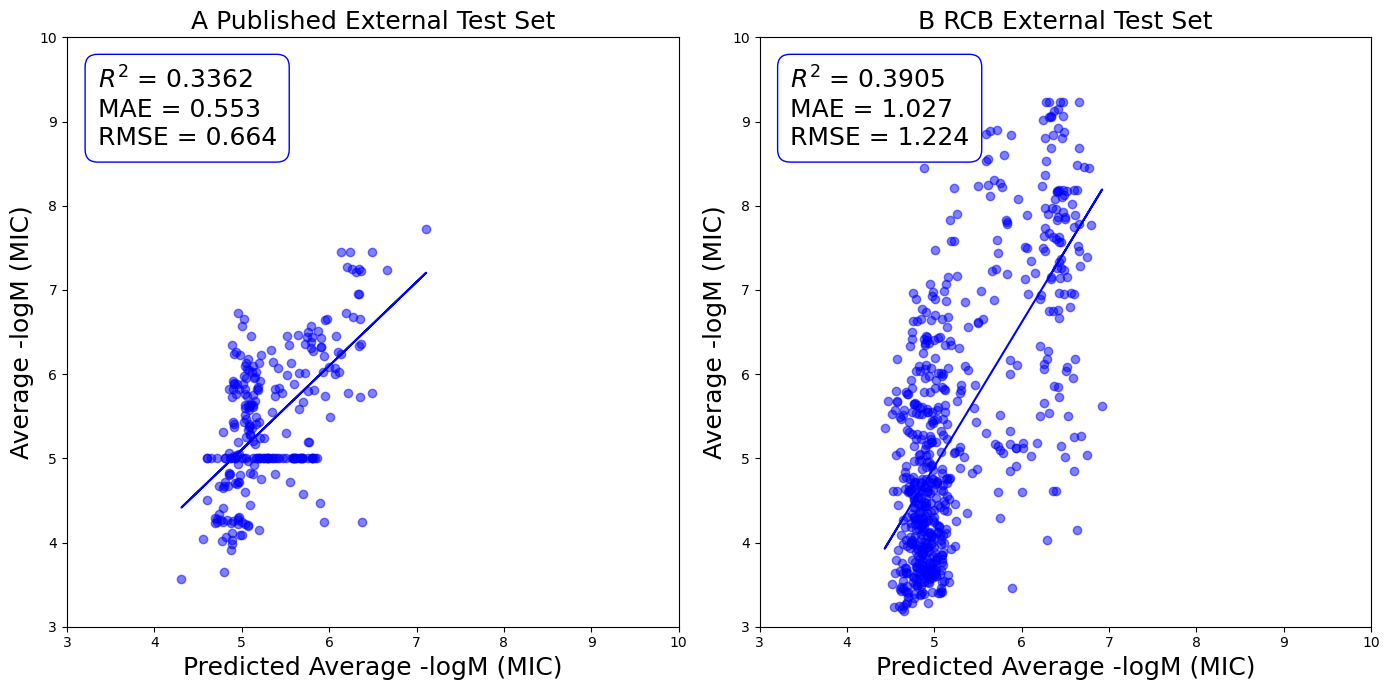

In [33]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression

def regression_scatter_plot(ax, y_test, y_pred, title='B RCB External Test Set'):
    y_test = np.array(y_test).reshape(-1, 1)
    y_pred = np.array(y_pred).reshape(-1, 1)
    reg = LinearRegression().fit(y_pred, y_test)
    y_fit = reg.predict(y_pred)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    ax.scatter(y_pred, y_test, color='blue', alpha=0.5)
    ax.plot(y_pred, y_fit, color='blue')
    ax.set_title(title, fontsize=18)
    ax.set_xlabel('Predicted Average -logM (MIC)', fontsize=18)
    ax.set_ylabel('Average -logM (MIC)', fontsize=18)
    ax.annotate(f'$R^2$ = {r2:.4f}\nMAE = {mae:.3f}\nRMSE = {rmse:.3f}', xy=(0.05, 0.95), xycoords='axes fraction',
                fontsize=18, verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', edgecolor='blue', facecolor='white'))
    ax.set_ylim(3, 10)
    ax.set_xlim(3, 10)


RCB_Mtb_inhibition_20072019['pred'] = y_pred_avg_RCB
tem = RCB_Mtb_inhibition_20072019[RCB_Mtb_inhibition_20072019['Activity'] > 3.15232]

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))
y_pred_avg_2017 = np.mean(predictions_dict['X_test_2017'], axis=0)
y_pred_avg_Vadim = np.mean(predictions_dict['X_test_Vadim'], axis=0)
y_pred_avg_RCB = np.mean(predictions_dict['X_test_RCB'], axis=0)



regression_scatter_plot(ax1, y_test_2017, y_pred_avg_2017, title='A Published External Test Set')
regression_scatter_plot(ax2, tem['Activity'], tem['pred'], title='B RCB External Test Set')

plt.tight_layout()
plt.show()

In [37]:
len(y_test_2017)

258